<a href="https://colab.research.google.com/github/Joboreh97/Codes-that-function/blob/main/tutorials/phy/functionalstyle_phasenoise_aware_64unit_pruned_demapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

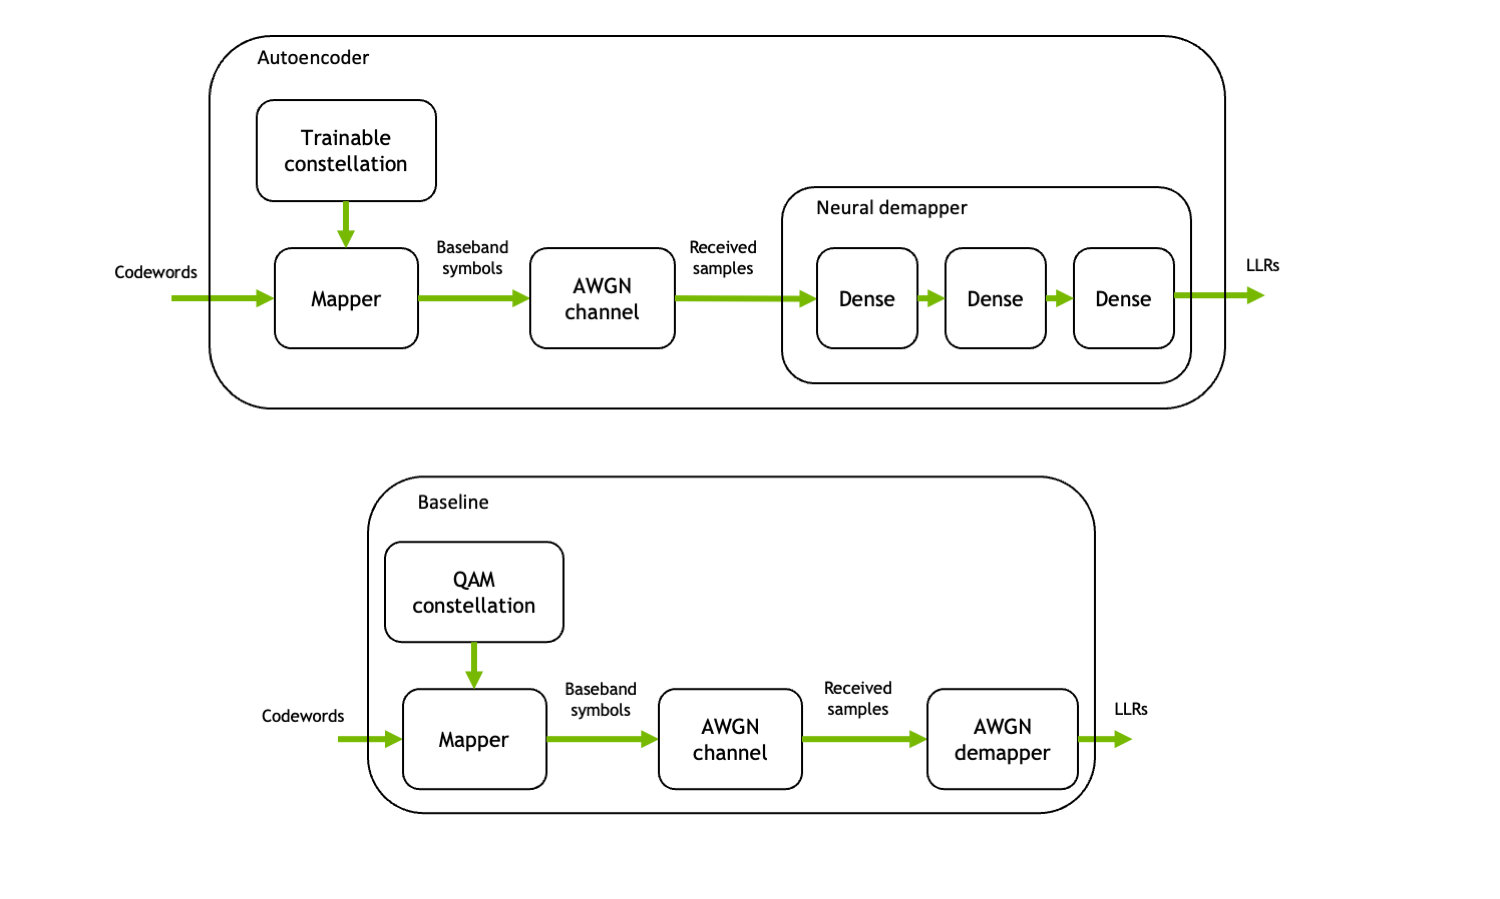


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [1]:
!pip show tensorflow
!pip show tf_keras

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, sionna, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: tensorflow
Required-by: dopamine_rl, tensorflow-hub, tensorflow_decision_forests


In [2]:
# ✅ Set this before importing TensorFlow to use legacy tf.keras (Keras 2)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Optional: Set GPU and logging behavior
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Add this to disable XNNPACK delegate for TFLite interpreter:
os.environ["TFLITE_ENABLE_XNNPACK"] = "0"
os.environ["TFLITE_DISABLE_SELECT_TF_OPS"] = "1"     # Add this
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"            # Add this too
# ✅ Now import TensorFlow and confirm it's using legacy Keras
import tensorflow as tf
import tf_keras
print("Legacy tf_keras version:", tf_keras.__version__)  # Should print 2.18.0

# ✅ Sionna setup
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print("Installing Sionna and restarting the runtime. Please run the cell again.")
        os.system("pip install sionna")
        os.kill(os.getpid(), 5)
    else:
        raise e

# ✅ GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# ✅ Suppress warnings from TF logger
tf.get_logger().setLevel('ERROR')

# ✅ Imports from tf.keras instead of standalone keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

# ✅ Sionna imports
from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

# ✅ Seed
sionna.phy.config.seed = 42

# ✅ Jupyter/plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle


Legacy tf_keras version: 2.18.0


In [3]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.6 MB/s eta 0:00:00


# Simulation Parameter

In [4]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 8.0

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 1000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700
num_training_iterations_rl_finetuning = 300
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_conventional_training_pruned = "awgn_autoencoder_weights_conventional_training_pruned" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_qat = "awgn_autoencoder_weights_qat" # Filename to save the autoencoder weights once QAT is done
model_weights_path_quantized_conventional_training = "awgn_autoencoder_quantized_weights_conventional_training"
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

# Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

**Neural Demapper for AWGN Channel**

In [5]:
def preprocess_complex_input(y, no, num_symbols_per_codeword):
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    no_db = log10_fn(no)  # shape: [batch_size, 1]
    re = tf.math.real(y)  # shape: [batch_size, num_symbols_per_codeword]
    im = tf.math.imag(y)

    # Broadcast no_db to match shape of re: [batch_size, num_symbols_per_codeword]
    no_db = tf.broadcast_to(no_db, tf.shape(re))

    # Stack into shape: [batch_size, num_symbols_per_codeword, 3]
    z = tf.stack([re, im, no_db], axis=-1)
    return z

In [6]:
from tensorflow.keras.layers import Input, Dense

def create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol):
    z_input = Input(shape=(num_symbols_per_codeword, 3), dtype=tf.float32, name="z_input")
    x = Dense(128, activation="relu")(z_input)
    x = Dense(128, activation="relu")(x)
    llr = Dense(num_bits_per_symbol)(x)
    return Model(inputs=z_input, outputs=llr, name="FunctionalDemapperReal")



In [7]:
import tensorflow_model_optimization as tfmot

# Float32 demapper
float_demapper = create_functional_demapper_real_input(
    num_symbols_per_codeword, num_bits_per_symbol)

# QAT wrapper
qat_demapper_model = tfmot.quantization.keras.quantize_model(float_demapper)



**Neural Demapper for (Phase Noise + AWGN) Channel**

In [8]:
# import tensorflow as tf
# from sionna.phy.utils import log10

# def preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword):
#     """
#     Preprocess inputs for the phase noise demapper *without* internal preprocessing.

#     Stacks real, imag parts of y, log10(no), and sigma_phi into a single tensor z.

#     Args:
#         y: complex tensor, shape [batch, num_symbols_per_codeword]
#         no: noise variance tensor, shape [batch, 1] or broadcastable
#         sigma_phi: phase noise stddev tensor, shape [batch, 1] or broadcastable
#         num_symbols_per_codeword: int

#     Returns:
#         z: float tensor, shape [batch, num_symbols_per_codeword, 4]
#            stacked [real(y), imag(y), log10(no), sigma_phi]
#     """
#     def log10_fn(x):
#         return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

#     no_db = log10_fn(no)   # shape [batch, 1]

#     # Tile no_db and sigma_phi to match symbols per codeword
#     no_db_tiled = tf.tile(no_db, [1, num_symbols_per_codeword])  # [batch, num_symbols_per_codeword]
#     batch_size = tf.shape(y)[0]  # or tf.shape(sigma_phi)[0] if appropriate
#    # Before stacking:
#     sigma_phi = tf.tile(sigma_phi, [tf.shape(y)[0], 1])  # Shape becomes [128, 250]

#     #sigma_phi_tiled = tf.tile(sigma_phi, [batch_size, num_symbols_per_codeword])
#     sigma_phi_tiled = tf.ones([batch_size, num_symbols_per_codeword], dtype=tf.float32) * sigma_phi


#     #sigma_phi_tiled = tf.tile(sigma_phi, [1, num_symbols_per_codeword])  # [batch, num_symbols_per_codeword]
#     # Before stacking, broadcast phi to match y's batch size


#     # Stack along last axis
#     z = tf.stack([
#         tf.math.real(y),
#         tf.math.imag(y),
#         no_db_tiled,
#         sigma_phi_tiled
#     ], axis=2)  # shape [batch, num_symbols_per_codeword, 4]

#     return z


In [9]:
import tensorflow as tf
from sionna.phy.utils import log10

def preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword):
    """
    Preprocess inputs for the phase noise demapper *without* internal preprocessing.

    Args:
        y: complex tensor, shape [batch, num_symbols_per_codeword]
        no: noise variance tensor, scalar or shape [batch, 1]
        sigma_phi: phase noise stddev tensor, scalar or shape [batch, 1]
        num_symbols_per_codeword: int

    Returns:
        z: float tensor, shape [batch, num_symbols_per_codeword, 4]

    """
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    batch_size = tf.shape(y)[0]

    # Ensure no and sigma_phi are broadcastable: reshape to [batch, 1] if needed
    no = tf.convert_to_tensor(no, dtype=tf.float32)
    sigma_phi = tf.convert_to_tensor(sigma_phi, dtype=tf.float32)

    # Expand dims if scalar or shape [1]
    no = tf.reshape(no, [-1, 1]) if len(no.shape) < 2 else no
    sigma_phi = tf.reshape(sigma_phi, [-1, 1]) if len(sigma_phi.shape) < 2 else sigma_phi

    # Convert no to dB and tile
    #no_db = log10(no)  # shape [batch, 1]
    no_db = log10_fn(no)   # shape [batch, 1]
    no_db_tiled = tf.tile(no_db, [1, num_symbols_per_codeword])  # shape [batch, num_symbols]

    # Tile sigma_phi
    sigma_phi_tiled = tf.tile(sigma_phi, [1, num_symbols_per_codeword])  # shape [batch, num_symbols]

    # Stack components along last axis
    z = tf.stack([
        tf.math.real(y),
        tf.math.imag(y),
        no_db_tiled,
        sigma_phi_tiled
    ], axis=2)  # shape [batch, num_symbols_per_codeword, 4]

    return z


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    # Define input shape: last dimension = 4 (from your preprocessing)
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")  # None for variable sequence length

    # Apply Dense layers
    x = Dense(512, activation='relu')(z_input)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)

    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None)(x)  # No activation for logits

    # Create the Keras model
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise")
    return model


In [11]:
# # Create demapper that expects preprocessed input z
# def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
#     dense_1 = Dense(512, activation='relu')
#     dense_2 = Dense(512, activation='relu')
#     dense_3 = Dense(512, activation='relu')
#     dense_out = Dense(num_bits_per_symbol if bitwise else 2**num_bits_per_symbol, activation=None)

#     def demapper(z):
#         llr = dense_1(z)
#         llr = dense_2(llr)
#         llr = dense_3(llr)
#         llr = dense_out(llr)
#         return llr

#     return demapper




In [12]:
float_demapper_phase_noise = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)

**Demapper Prunning**

In [13]:
 pruning_params = {
            "initial_sparsity": 0.0,
            "final_sparsity": 0.875,
            "begin_step": 0,
            "end_step": 1000,
         }

In [14]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

def create_pruned_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, pruning_params, bitwise=True):
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=pruning_params["initial_sparsity"],
        final_sparsity=pruning_params["final_sparsity"],
        begin_step=pruning_params["begin_step"],
        end_step=pruning_params["end_step"],
    )
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Define input layer with unspecified shape except feature dimension
    #z_input = Input(shape=(None, ), dtype=tf.float32, name="z_input")
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    # Apply pruning wrapper to Dense layers
    x = prune_low_magnitude(Dense(512, activation='relu'), pruning_schedule=pruning_schedule)(z_input)
    x = prune_low_magnitude(Dense(512, activation='relu'), pruning_schedule=pruning_schedule)(x)
    x = prune_low_magnitude(Dense(512, activation='relu'), pruning_schedule=pruning_schedule)(x)

    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = prune_low_magnitude(Dense(output_units, activation=None), pruning_schedule=pruning_schedule)(x)

    # Create Keras model
    model = Model(inputs=z_input, outputs=llr, name="PrunedFunctionalDemapperPhaseNoise")
    return model


**Phase Noise**

In [15]:
class PhaseNoise(Block):
    def __init__(self, *, precision=None, **kwargs):
        super().__init__(precision=precision, **kwargs)

    def call(self, x, sigma):
        phi = tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=1.0,
            dtype=self.rdtype
        )
        sigma = expand_to_rank(sigma, tf.rank(x), axis=-1)
        sigma = tf.cast(sigma, self.rdtype)
        phi *= sigma
        phase_rotation = tf.complex(tf.math.cos(phi), tf.math.sin(phi))
        return x * phase_rotation


**Phase Noise Gaussian**

In [16]:

#5:35 PM







import tensorflow_probability as tfp

import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer
from sionna.phy.channel import AWGN
import numpy as np
from sionna.phy.utils import expand_to_rank, complex_normal

from tensorflow.keras.layers import Layer
class PhaseNoiseGaussian(Layer):
    """
    Gaussian Distribution based Phase Noise process.

Forward call takes N0 for AWGN and sigma_phi for Gaussian distribution.

:param start_phase_width: upper bound for initialization
                          with a uniform distribution.
:param start_phase_init: initial phase value at the start of the
                         generation for each noise sequence.
"""

    def __init__(self, dtype=tf.complex64, **kwargs):
        """Construct PhasenoiseGaussian."""
        #super(PhasenoiseWiener, self).__init__()
        super().__init__(dtype=dtype, **kwargs)
        self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype
        self.start_phase_init = -1*np.pi #kwargs.start_phase_init
        self.start_phase_width = np.pi # kwargs.start_phase_width


    def call(self, inputs):
        """
        Apply only Gaussian phase noise.

        Parameters
        ----------
        x: array_like
          Input data
        """
        print('*********Inside Gaussian Distributed PN************')

        x, sigma_phi = inputs
        var = 1.0
        var_dim = tf.cast(var, x.dtype.real_dtype)/tf.cast(2, x.dtype.real_dtype)
        stddev = tf.sqrt(var_dim)
        # Create tensors of real-valued Gaussian noise for each complex dim.
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype.real_dtype)
        # Add extra dimensions for broadcasting
        sigma_phi = expand_to_rank(sigma_phi, tf.rank(x), axis=-1)

        # Apply variance scaling
        sigma_phi = tf.cast(sigma_phi, self._real_dtype)

        noise *= tf.cast(sigma_phi, noise.dtype)

        pnr = tf.math.cos(noise)
        pni = tf.math.sin(noise)
        pn = tf.complex(pnr,pni)

        # # Add noise to input
        # y = x*pn

        return x*pn

In [17]:
# class PhaseNoiseGaussian(Layer):  # Use Layer, not Block, unless you have a custom Block base class
#     """
#     Gaussian Distribution based Phase Noise process.
#     """

#     def __init__(self, dtype=tf.complex64, **kwargs):
#         super().__init__(dtype=dtype, **kwargs)
#         self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype
#         self.start_phase_init = -1 * np.pi
#         self.start_phase_width = np.pi

#     def call(self, inputs):
#         print('*********Inside Gaussian Distributed PN************')
#         x, sigma_phi = inputs
#         var = 1.0
#         var_dim = tf.cast(var, x.dtype.real_dtype) / tf.cast(2, x.dtype.real_dtype)
#         stddev = tf.sqrt(var_dim)
#         noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype.real_dtype)
#         sigma_phi = expand_to_rank(sigma_phi, tf.rank(x), axis=-1)
#         sigma_phi = tf.cast(sigma_phi, self._real_dtype)
#         noise *= tf.cast(sigma_phi, noise.dtype)
#         pnr = tf.math.cos(noise)
#         pni = tf.math.sin(noise)
#         pn = tf.complex(pnr, pni)
#         return x * pn


## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [18]:
class E2ESystemConventionalTraining(Model):

    def __init__(self, training):
        super().__init__()

        self._training = training

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        # Fixed constellation points (untrainable)
        qam_points = Constellation("qam", num_bits_per_symbol).points
        self.constellation = Constellation("custom",
                                           num_bits_per_symbol,
                                           points=qam_points,
                                           normalize=True,
                                           center=True)

        # To make the constellation trainable, we need to create seperate
        # variables for the real and imaginary parts
        self.points_r = self.add_weight(shape=qam_points.shape,
                                        initializer="zeros")
        self.points_i = self.add_weight(shape=qam_points.shape,
                                        initializer="zeros")
        self.points_r.assign(tf.math.real(qam_points))
        self.points_i.assign(tf.math.imag(qam_points))



        # No trainable variables for constellation points here!

        self._mapper = Mapper(constellation=self.constellation)

        ################
        ## Channel
        ################
        self._phase_noise = PhaseNoiseGaussian()

        self._channel = AWGN()

        ################
        ## Receiver
        ################
        # Functional demapper remains trainable
        # self._demapper = float_demapper

        self._demapper = float_demapper_phase_noise

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):
        # No reassignment of constellation points needed — points fixed at init
        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db) if len(ebno_db.shape) == 0 else ebno_db

        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)
        ################
        ## Transmitter
        ################
        if self._training:
            c = self._binary_source([batch_size, n])
        else:
            b = self._binary_source([batch_size, k])
            c = self._encoder(b)
        x = self._mapper(c)

        ################
        ## Channel
        ################

        #sigma_phi = tf.constant(0.01, dtype=no.dtype)  # Phase noise stddev; can be made trainable or passed in
        sigma_phi = tf.fill([batch_size, 1], 0.01)  # Shape [batch_size, 1]

        x_phase_noisy = self._phase_noise((x, sigma_phi))
        y = self._channel(x_phase_noisy, no)


        ################
        ## Receiver
        ################
        #z = preprocess_complex_input(y, no, num_symbols_per_codeword)
        z = preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword)
        llr = self._demapper(z)  # shape (batch_size, 250, 6) expected

        # If llr is flattened to (batch_size, 1500), reshape it:
       # llr = tf.reshape(llr, [batch_size, 250, 6])

        #llr = tf.reshape(llr, [batch_size, n])
        if self._training:
            c_reshaped = tf.reshape(c, [batch_size, num_symbols_per_codeword, num_bits_per_symbol])  # (128, 250, 6)
            loss = self._bce(c_reshaped, llr)

            return loss

        else:
            llr_reshaped = tf.reshape(llr, [batch_size, n])
            b_hat = self._decoder(llr_reshaped)
            return b, b_hat



 # Ground truth and reconstructed information bits returned for BER/BLER computation

A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [19]:
def conventional_training(model):
    # Optimizer used to apply gradients
    optimizer = tf.keras.optimizers.Adam()

    @tf.function(jit_compile=True)
    def train_step():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            loss = model(training_batch_size,  ebno_db)
        # Computing and applying gradients
        weights = model.trainable_variables
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        return loss

    for i in range(num_training_iterations_conventional):
        loss = train_step()
        # Check for NaNs in model weights
        for w in model.trainable_variables:
            if tf.math.reduce_any(tf.math.is_nan(w)):
                print(f"NaN detected in weights at iteration {i}!")
                return  # Stop training if NaN detected
        if i % 100 == 0:
            print(f"Iteration {i}/{num_training_iterations_conventional} BCE: {loss.numpy():.4f}", end='\r')

In [20]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In [21]:
# def load_weights(model, model_weights_path):
#     with open(model_weights_path, 'rb') as f:
#         weights = pickle.load(f)
#     model.set_weights(weights)


In [22]:
# Utility function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(tf.cast(1, tf.int32), tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    points = tf.complex(model.points_r, model.points_i)
    model.constellation.points = points

The next cell defines a utility function for saving the weights using [pickle](https://docs.python.org/3/library/pickle.html).

In the next cell, an instance of the model defined previously is instantiated and trained.

In [23]:
# 1️⃣ Train and save original (unquantized) model
model_float = E2ESystemConventionalTraining(training=True)
conventional_training(model_float)

# Save only unquantized weights
save_weights(model_float, model_weights_path_conventional_training)
# Save full model (architecture + weights + config)
#model_float.save("awgn_autoencoder_model.keras")

*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


In [24]:
# 2️⃣ Evaluate conventional model from fresh weights
model_conventional = E2ESystemConventionalTraining(training=False)
load_weights(model_conventional, model_weights_path_conventional_training)





*********Inside Gaussian Distributed PN************


In [25]:
model_conventional.get_weights()

[array([[ 0.04061118,  0.02703319,  0.1248135 , ...,  0.05156025,
         -0.00180915, -0.06645494],
        [-0.03400519,  0.01631456, -0.11077705, ..., -0.03048353,
          0.0680201 ,  0.11316194],
        [-0.126248  ,  0.08684607,  0.01842747, ..., -0.08892647,
         -0.07984737, -0.11111014],
        [ 0.03518383, -0.04102678, -0.10001832, ...,  0.00365333,
         -0.01144463, -0.05041559]], dtype=float32),
 array([ 0.01328105, -0.0069332 , -0.04252391, -0.02696938,  0.01996157,
         0.02977816,  0.06849354, -0.07675892,  0.06782123, -0.00806903,
        -0.05698701, -0.04042349,  0.04011934, -0.08133025,  0.03800431,
        -0.06193898, -0.08658417, -0.01915435, -0.05757533, -0.05965962,
         0.07280754, -0.05777054, -0.0310926 , -0.0122559 ,  0.11249875,
        -0.04523738, -0.02340476,  0.04613311,  0.0034479 , -0.03228024,
         0.07607111, -0.06324458, -0.04563997,  0.08956699,  0.00887119,
         0.03267595,  0.04377605,  0.07412928, -0.08030665, -0.0

In [26]:
import tensorflow as tf

class E2ESystemConventionalTraining_Pruned(tf.keras.Model):
    def __init__(self, num_symbols_per_codeword, num_bits_per_symbol, n, pruning_params):
        super().__init__()
        self.n = n
        self._demapper = create_pruned_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, pruning_params, bitwise=True)

    def call(self, inputs, training=None):
        z = inputs  # z: [batch, num_symbols_per_codeword, 3]


        llr = self._demapper(z)  # [batch, num_symbols_per_codeword, num_bits_per_symbol]
        # Reshape to [batch, n]
       # llr = tf.reshape(llr, [tf.shape(z)[0], -1])
        return llr


In [27]:
# Example: initialize all required objects
# Load trained conventional model
trained_model = E2ESystemConventionalTraining(training=False)
load_weights(trained_model, model_weights_path_conventional_training)
binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)  # or None if not used
qam_points = Constellation("qam", num_bits_per_symbol).points

# Extract trained constellation points
points_r = trained_model.points_r
points_i = trained_model.points_i
trainable_points = tf.complex(points_r, points_i)

# Create a custom constellation object with trainable points
constellation = Constellation("custom",
                              num_bits_per_symbol,
                              points=trainable_points,
                              normalize=True,
                              center=True)

#constellation = Constellation("custom", num_bits_per_symbol, points=qam_points, normalize=True, center=True)
mapper = Mapper(constellation=constellation)
channel = AWGN()
phase_noise = PhaseNoiseGaussian()
# preprocess_complex_input: your function as before




*********Inside Gaussian Distributed PN************


In [28]:
def synthetic_data_generator(batch_size, num_symbols_per_codeword, num_bits_per_symbol, n, k,
                            coderate, qam_points, constellation, mapper, encoder, channel, preprocess_complex_phase_noise_input, ebno_db_min, ebno_db_max):
    while True:
        # 1. Generate random Eb/No values for each batch
        ebno_db = np.random.uniform(ebno_db_min, ebno_db_max, size=(batch_size,)).astype(np.float32)
        # 2. Generate random information bits of length k
        b = np.random.randint(0, 2, size=(batch_size, k)).astype(np.float32)
        # 3. Encode to codeword length n
        if encoder is not None:
            c = encoder(b)
        else:
            c = b  # If no encoder, treat as codeword
        # 4. Map to constellation
        x = mapper(c)
        # 5. Calculate noise variance per batch
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)
        #Phase noise consideration
        #sigma_phi = tf.constant(0.01, dtype=no.dtype)  # Phase noise stddev; can be made trainable or passed in
        sigma_phi = tf.fill([batch_size, 1], 0.01)

        x_phase_noisy = phase_noise((x, sigma_phi))


        # 6. Pass through AWGN channel and phase noise channel
        y = channel(x_phase_noisy, no)
        # 7. Preprocess (convert complex to real-valued input for demapper)
        z = preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword)
        c_reshaped = np.reshape(c, (batch_size, num_symbols_per_codeword, num_bits_per_symbol))
        yield z, c_reshaped



In [29]:
batch_size = 128  # or whatever value you want

train_dataset = tf.data.Dataset.from_generator(
    lambda: synthetic_data_generator(
        batch_size, num_symbols_per_codeword, num_bits_per_symbol, n, k,
        coderate, qam_points, constellation, mapper, encoder, channel,  preprocess_complex_phase_noise_input, ebno_db_min, ebno_db_max
    ),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, num_symbols_per_codeword, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, num_symbols_per_codeword, num_bits_per_symbol), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)


In [30]:
import tensorflow_model_optimization as tfmot

model = E2ESystemConventionalTraining_Pruned(
    num_symbols_per_codeword,
    num_bits_per_symbol,
    n,
    pruning_params
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs')
]

model.fit(
    train_dataset,
    steps_per_epoch=num_training_iterations_conventional,
    epochs=1,
    callbacks=callbacks
)



*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
1000/1000 [==============================] - 1491s 1s/step - loss: 0.3050


In [31]:
# After training, strip pruning
model._demapper = tfmot.sparsity.keras.strip_pruning(model._demapper)
model._demapper.save_weights('pruned_demapper_weights.h5')

In [32]:
model.trainable_variables

[<tf.Variable 'prune_low_magnitude_dense_7/kernel:0' shape=(4, 512) dtype=float32, numpy=
 array([[-0.        ,  0.        , -0.        , ...,  0.        ,
          0.        , -0.        ],
        [-0.        , -0.22634111,  0.        , ..., -0.18540424,
         -0.1924814 , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        ,  0.        ],
        [-0.        ,  0.        , -0.17031127, ...,  0.        ,
          0.        , -0.        ]], dtype=float32)>,
 <tf.Variable 'prune_low_magnitude_dense_7/bias:0' shape=(512,) dtype=float32, numpy=
 array([-0.03777645,  0.08196263, -0.09699667, -0.05283289, -0.09778495,
         0.03275556, -0.07591464,  0.01560835, -0.1003336 , -0.04677176,
        -0.04163299, -0.06170004,  0.05271   , -0.07006624,  0.00918279,
         0.09987462,  0.02250549, -0.00571327,  0.06698591, -0.03425122,
        -0.02888167,  0.1010773 ,  0.00134219, -0.11143914,  0.01819884,
         0.08258542,  0.10548051,

In [33]:
# optimizer = tf.keras.optimizers.Adam()
# qat_demapper_model.compile(
#     optimizer=optimizer,
#     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# )


# qat_demapper_model.fit(
#     train_dataset,
#     steps_per_epoch=1000,  # or as needed
#     epochs=1
# )

# qat_demapper_model.save_weights('qat_demapper_qat_weights.h5')


In [34]:
import numpy as np

print("Sparsity of pruned layers after training:")
for layer in model._demapper.layers:
    weights = layer.get_weights()
    if weights:
        kernel = weights[0]  # The kernel is usually the first weight
        num_zeros = np.sum(kernel == 0)
        total_weights = kernel.size
        sparsity = num_zeros / total_weights
        print(f"Layer '{layer.name}' sparsity: {sparsity:.2%}")

Sparsity of pruned layers after training:
Layer 'dense_7' sparsity: 87.50%
Layer 'dense_8' sparsity: 87.50%
Layer 'dense_9' sparsity: 87.50%
Layer 'dense_10' sparsity: 87.50%


In [35]:
class E2ESystemConventionalTraining_Pruned(Model):

    def __init__(self, training):
        super().__init__()

        self._training = training

        # ✅ Make sure this dictionary is defined right here
        pruning_params = {
            "initial_sparsity": 0.0,
            "final_sparsity": 0.875,
            "begin_step": 0,
            "end_step": 1000,
        }




        # ✅ Make sure this dictionary is defined right here

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        # Untrainable constellation
        qam_points = Constellation("qam", num_bits_per_symbol).points
        self.constellation = Constellation("custom",
                                           num_bits_per_symbol,
                                           points=qam_points,
                                           normalize=True,
                                           center=True)

         # To make the constellation trainable, we need to create seperate
        # variables for the real and imaginary parts
        self.points_r = self.add_weight(shape=qam_points.shape,
                                        initializer="zeros")
        self.points_i = self.add_weight(shape=qam_points.shape,
                                        initializer="zeros")
        self.points_r.assign(tf.math.real(qam_points))
        self.points_i.assign(tf.math.imag(qam_points))


        self._mapper = Mapper(constellation=self.constellation)

        ################
        ## Channel
        ################

        self._phase_noise = PhaseNoiseGaussian()
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = float_demapper_phase_noise
        self._demapper.load_weights('pruned_demapper_weights.h5')  # Load trained weights
        self._demapper.trainable = False  # <--- THIS FREEZES THE DEMAPPER
        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):

        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        # Ensure ebno_db has rank ≥1
        if len(ebno_db.shape) == 0:  # If scalar
            #ebno_db = tf.reshape(ebno_db, [1])  # Convert to rank-1 tensor
            ebno_db = tf.fill([batch_size], ebno_db) if len(ebno_db.shape) == 0 else ebno_db
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        if self._training:
            c = self._binary_source([batch_size, n])
        else:
            b = self._binary_source([batch_size, k])
            c = self._encoder(b)

        x = self._mapper(c)

        ################
        ## Channel
        ################
        #y = self._channel(x, no)

        #sigma_phi = tf.constant(0.1, dtype=no.dtype)  # Phase noise stddev; can be made trainable or passed in
        sigma_phi = tf.fill([batch_size, 1], 0.01)  # Shape [batch_size, 1]

        x_phase_noisy = self._phase_noise((x, sigma_phi))  # pass as a single tuple argument

        y = self._channel(x_phase_noisy, no)

        ################
        ## Receiver
        ################
        # NEW: Convert complex y + noise variance into real-valued input
        z = preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword)


        # Feed real-valued input to quantized demapper
        llr = self._demapper(z)

        # Reshape output to [batch_size, n]
        #llr = tf.reshape(llr, [batch_size, n])

        if self._training:
            c_reshaped = tf.reshape(c, [batch_size, num_symbols_per_codeword, num_bits_per_symbol])  # (128, 250, 6)
            loss = self._bce(c_reshaped, llr)
            return loss
        else:
            llr_reshaped = tf.reshape(llr, [batch_size, n])
            b_hat = self._decoder(llr_reshaped)
            return b, b_hat

 # Ground truth and reconstructed information bits returned for BER/BLER computation

In [36]:
model_pruned =  E2ESystemConventionalTraining_Pruned(training=True)
conventional_training(model_pruned)
save_weights(model_pruned, model_weights_path_conventional_training_pruned)

*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


In [37]:
import numpy as np
for layer in model_pruned._demapper.layers:
    weights = layer.get_weights()
    if weights:
        kernel = weights[0]
        num_zeros = np.sum(kernel == 0)
        total_weights = kernel.size
        sparsity = num_zeros / total_weights
        print(f"Layer '{layer.name}' sparsity: {sparsity:.2%}")

Layer 'dense_3' sparsity: 87.50%
Layer 'dense_4' sparsity: 87.50%
Layer 'dense_5' sparsity: 87.50%
Layer 'dense_6' sparsity: 87.50%


In [38]:
model_pruned_eval = E2ESystemConventionalTraining_Pruned(training=False)


# Now load the weights
load_weights(model_pruned_eval, model_weights_path_conventional_training_pruned)

*********Inside Gaussian Distributed PN************


In [39]:
model_conventional.get_weights()

[array([[-0.        ,  0.        , -0.        , ...,  0.        ,
          0.        , -0.        ],
        [-0.        , -0.22634111,  0.        , ..., -0.18540424,
         -0.1924814 , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        ,  0.        ],
        [-0.        ,  0.        , -0.17031127, ...,  0.        ,
          0.        , -0.        ]], dtype=float32),
 array([-0.03777645,  0.08196263, -0.09699667, -0.05283289, -0.09778495,
         0.03275556, -0.07591464,  0.01560835, -0.1003336 , -0.04677176,
        -0.04163299, -0.06170004,  0.05271   , -0.07006624,  0.00918279,
         0.09987462,  0.02250549, -0.00571327,  0.06698591, -0.03425122,
        -0.02888167,  0.1010773 ,  0.00134219, -0.11143914,  0.01819884,
         0.08258542,  0.10548051,  0.03462363, -0.09082077, -0.05477956,
         0.11732769,  0.10014498,  0.10155558, -0.06507959, -0.07762245,
        -0.06251385,  0.00051322, -0.02134112,  0.12572968, -0.0

In [40]:
model_pruned.get_weights()

[array([[-0.        ,  0.        , -0.        , ...,  0.        ,
          0.        , -0.        ],
        [-0.        , -0.22634111,  0.        , ..., -0.18540424,
         -0.1924814 , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        ,  0.        ],
        [-0.        ,  0.        , -0.17031127, ...,  0.        ,
          0.        , -0.        ]], dtype=float32),
 array([-0.03777645,  0.08196263, -0.09699667, -0.05283289, -0.09778495,
         0.03275556, -0.07591464,  0.01560835, -0.1003336 , -0.04677176,
        -0.04163299, -0.06170004,  0.05271   , -0.07006624,  0.00918279,
         0.09987462,  0.02250549, -0.00571327,  0.06698591, -0.03425122,
        -0.02888167,  0.1010773 ,  0.00134219, -0.11143914,  0.01819884,
         0.08258542,  0.10548051,  0.03462363, -0.09082077, -0.05477956,
         0.11732769,  0.10014498,  0.10155558, -0.06507959, -0.07762245,
        -0.06251385,  0.00051322, -0.02134112,  0.12572968, -0.0

In [41]:
# class E2ESystemConventionalTrainingQat(Model):

#     def __init__(self, training):
#         super().__init__()

#         self._training = training

#         ################
#         ## Transmitter
#         ################
#         self._binary_source = BinarySource()
#         if not self._training:
#             self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

#         # Fixed constellation points (untrainable)
#         qam_points = Constellation("qam", num_bits_per_symbol).points
#         self.constellation = Constellation("custom",
#                                            num_bits_per_symbol,
#                                            points=qam_points,
#                                            normalize=True,
#                                            center=True)

#         # No trainable variables for constellation points here!

#         self._mapper = Mapper(constellation=self.constellation)

#         ################
#         ## Channel
#         ################
#         self._phase_noise = PhaseNoise()
#         self._channel = AWGN()

#         ################
#         ## Receiver
#         ################
#         # Functional demapper remains trainable
#         self._demapper = float_demapper
#         self._demapper = tfmot.quantization.keras.quantize_model(self._demapper)
#         self._demapper.load_weights('qat_demapper_qat_weights.h5') # Load trained weights
#         self._demapper.trainable = False

#         if not self._training:
#             self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

#         #################
#         # Loss function
#         #################
#         if self._training:
#             self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#     def call(self, batch_size, ebno_db):
#         # No reassignment of constellation points needed — points fixed at init

#         if len(ebno_db.shape) == 0:
#             ebno_db = tf.fill([batch_size], ebno_db) if len(ebno_db.shape) == 0 else ebno_db

#         no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
#         no = expand_to_rank(no, 2)

#         ################
#         ## Transmitter
#         ################
#         if self._training:
#             c = self._binary_source([batch_size, n])
#         else:
#             b = self._binary_source([batch_size, k])
#             c = self._encoder(b)
#         x = self._mapper(c)

#         ################
#         ## Channel
#         ################
#         sigma_phi = tf.constant(0.1, dtype=no.dtype)  # Phase noise stddev; can be made trainable or passed in
#         x_phase_noisy = self._phase_noise(x, sigma_phi)
#         y = self._channel(x_phase_noisy, no)
#         #y = self._channel(x, no)

#         ################
#         ## Receiver
#         ################
#         z = preprocess_complex_input(y, no, num_symbols_per_codeword)
#         llr = self._demapper(z)

#         llr = tf.reshape(llr, [batch_size, n])
#         if self._training:
#             loss = self._bce(c, llr)
#             return loss
#         else:
#             b_hat = self._decoder(llr)
#             return b, b_hat


In [42]:

# # QAT training model
# model_qat = E2ESystemConventionalTrainingQat(training=True)
# conventional_training(model_qat)
# save_weights(model_qat, model_weights_path_qat)

# # Save full model (architecture + weights + config)
# #model_float.save("awgn_autoencoder_qat_model.keras")

In [43]:
def representative_data_gen():
    for _ in range(100):
        # Use float32, matching the model input, and now with 4 features
        dummy_input = np.random.randn(1, num_symbols_per_codeword, 4).astype(np.float32)
        yield [dummy_input]



In [44]:
!pip install -U tensorflow-model-optimization


In [45]:
def manually_strip_fake_quant_layers(model):
    import tensorflow as tf
    import tensorflow_model_optimization as tfmot

    # Dynamically locate QuantizeWrapper class
    QuantizeWrapper = None
    for attr in dir(tfmot.quantization.keras):
        obj = getattr(tfmot.quantization.keras, attr)
        if isinstance(obj, type) and "QuantizeWrapper" in obj.__name__:
            QuantizeWrapper = obj
            break
    if QuantizeWrapper is None:
        raise ImportError("QuantizeWrapper not found in tfmot.quantization.keras")

    def _clone_layer(layer):
        if isinstance(layer, QuantizeWrapper):
            # Extract the original layer
            original_layer = layer.layer

            # Fix any wrapped QuantizeAwareActivation
            config = original_layer.get_config()
            if 'activation' in config and isinstance(config['activation'], dict):
                act_cfg = config['activation']
                if 'class_name' in act_cfg and act_cfg['class_name'] == 'QuantizeAwareActivation':
                    config['activation'] = act_cfg['config']['activation']  # e.g., 'relu'
            return original_layer.__class__.from_config(config)

        return layer

    return tf.keras.models.clone_model(model, clone_function=_clone_layer)




In [46]:

# model_temp = E2ESystemConventionalTrainingQat(training=False)
# load_weights(model_temp, model_weights_path_qat)


In [47]:
# model_temp.get_weights()

**Post Training Quantization**

In [48]:
import tensorflow as tf

# Modify converter settings
converter = tf.lite.TFLiteConverter.from_keras_model(model_conventional._demapper)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_disable_quant_scale_range_check = True

tflite_quant_model = converter.convert()

# Save quantized TFLite model
with open("quantized_demapper.tflite", "wb") as f:
    f.write(tflite_quant_model)

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [49]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_details = interpreter.get_input_details()
print(input_details[0]['dtype'])  # Should be np.float32 or np.uint8


<class 'numpy.int8'>


In [50]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="quantized_demapper.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input dtype:", input_details[0]['dtype'])    # e.g., np.float32 or np.uint8
print("Output dtype:", output_details[0]['dtype'])  # e.g., np.float32 or np.uint8


Input dtype: <class 'numpy.int8'>
Output dtype: <class 'numpy.int8'>


In [51]:
class QuantizedDemapperWrapper(tf.keras.layers.Layer):
    def __init__(self, interpreter_path):
        super().__init__()
        # Force single-threaded CPU execution
        self.interpreter = tf.lite.Interpreter(
            model_path=interpreter_path,
            experimental_delegates=[],
            num_threads=1  # Already correct in your code
        )
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.output_details = self.interpreter.get_output_details()

    def _wrapped_call_single(self, z_single):
      input_scale = self.input_details[0]['quantization'][0]
      input_zero_point = self.input_details[0]['quantization'][1]
      z_quant = np.round(z_single / input_scale + input_zero_point)
      z_quant = np.clip(z_quant, -128, 127).astype(np.int8)
      # Ensure batch dimension is present
      if z_quant.ndim == 2:
          z_quant = np.expand_dims(z_quant, axis=0)
      self.interpreter.set_tensor(self.input_details[0]['index'], z_quant)
      self.interpreter.invoke()
      output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
      output_scale, output_zero_point = self.output_details[0]['quantization']
      output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
      return output_float[0]


    def call(self, z):
        # z shape: (batch_size, 250, 3)
        return tf.map_fn(
            lambda x: tf.py_function(self._wrapped_call_single, [x], tf.float32),
            z,
            fn_output_signature=tf.TensorSpec(shape=(250, 6), dtype=tf.float32)
        )



In [52]:
model_quantized =E2ESystemConventionalTraining(training=False)
load_weights(model_quantized, model_weights_path_conventional_training)  # load everything else

# Replace demapper with quantized TFLite wrapper
model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")
save_weights(model_quantized, model_weights_path_quantized_conventional_training)


*********Inside Gaussian Distributed PN************


## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [53]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x, no) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [54]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [55]:
# # Utility function to load and set weights of a model
# def load_weights(model, model_weights_path):
#     model(tf.cast(1, tf.int32), tf.constant(10.0, tf.float32))
#     with open(model_weights_path, 'rb') as f:
#         weights = pickle.load(f)
#     model.set_weights(weights)
#     points = tf.complex(model.points_r, model.points_i)
#     model.constellation.points = points

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [56]:

# Dictionary storing the results
BER = {}

model_baseline = Baseline()
ber, _ = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['baseline'] = ber.numpy()

# model_conventional
# ebno_dbs = tf.convert_to_tensor(ebno_dbs, dtype=tf.float32)
# ebno_dbs = tf.reshape(ebno_dbs, [-1])  # Ensure rank-1
ber, _ = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['autoencoder-conv'] = ber.numpy()

ber, _ = sim_ber(model_pruned_eval, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode= None)
BER['autoencoder-pruned'] = ber.numpy()

# model_quantized
# ebno_dbs = tf.convert_to_tensor(ebno_dbs, dtype=tf.float32)
# ebno_dbs = tf.reshape(ebno_dbs, [-1])  # Ensure rank-1
ber, _ = sim_ber(model_quantized, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-quantized'] = ber.numpy()

# # model_rl (if you want BER for RL as well)
# model_rl = E2ESystemRLTraining(training=False)
# load_weights(model_rl, model_weights_path_rl_training)
# ber, _ = sim_ber(model_rl, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000, graph_mode="xla")
# BER['autoencoder-rl'] = ber.numpy()

with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.2345e-01 | 1.0000e+00 |       94807 |      768000 |         1024 |        1024 |        13.0 |reached target block errors
      4.5 | 9.8382e-02 | 9.9805e-01 |       75557 |      768000 |         1022 |        1024 |         6.0 |reached target block errors
      5.0 | 5.8964e-02 | 9.2188e-01 |       50945 |      864000 |         1062 |        1152 |         3.5 |reached target block errors
      5.5 | 1.8709e-02 | 5.0000e-01 |       28737 |     1536000 |         1024 |        2048 |         5.9 |reached target block errors
      6.0 | 2.3856e-03 | 1.0747e-01 |       16947 |     7104000 |         1018 |        9472 |        26.3 |reached target block errors
      6.5 | 8.6146e-05 | 8.2031e-03 |         827 |     9600000 |

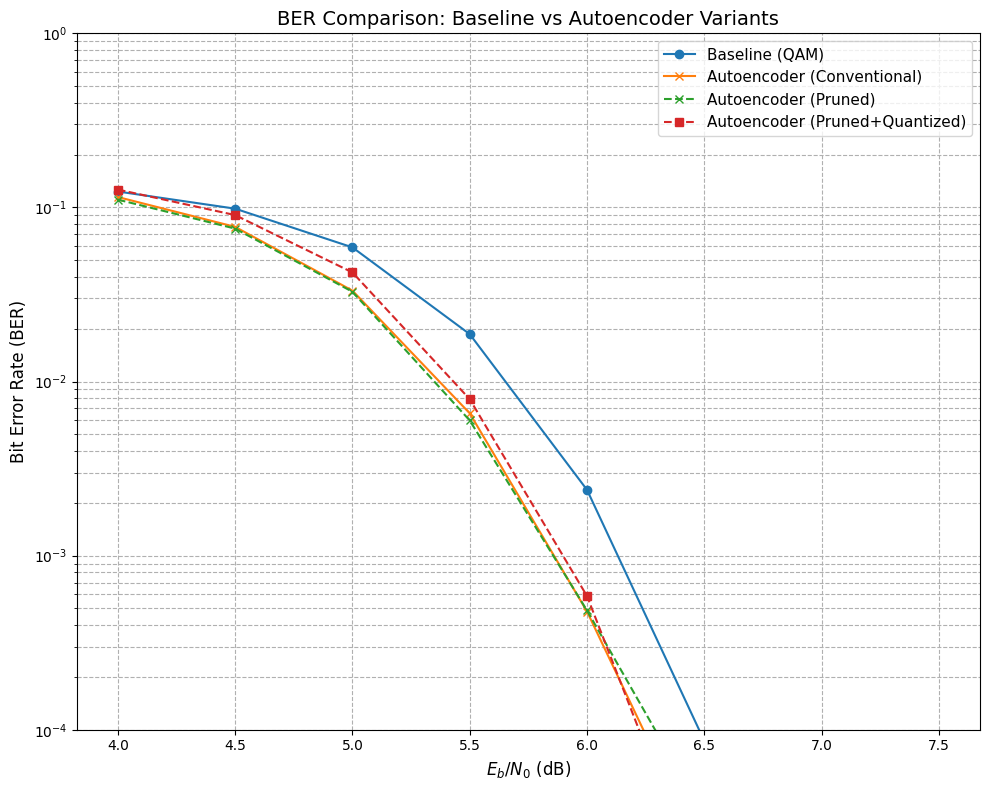

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Baseline (e.g., QAM)
plt.semilogy(ebno_dbs, BER['baseline'], 'o-', color='C0', label='Baseline (QAM)')

# Autoencoder (conventional training)
plt.semilogy(ebno_dbs, BER['autoencoder-conv'], 'x-', color='C1', label='Autoencoder (Conventional)')

# Autoencoder (QAT-trained)
plt.semilogy(ebno_dbs, BER['autoencoder-pruned'], 'x--', color='C2', label='Autoencoder (Pruned)')

# Autoencoder (Post-Training Quantized)
plt.semilogy(ebno_dbs, BER['autoencoder-quantized'], 's--', color='C3', label='Autoencoder (Pruned+Quantized)')

plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=12)
plt.ylabel("Bit Error Rate (BER)", fontsize=12)
plt.title("BER Comparison: Baseline vs Autoencoder Variants", fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.8)
plt.ylim((1e-4, 1.0))
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [58]:
print("Quantized model evaluation:")
for layer in model_quantized.layers:
    print(layer.__class__.__name__)


Quantized model evaluation:
PhaseNoiseGaussian
QuantizedDemapperWrapper


In [59]:
# plt.figure(figsize=(10,8))
# # Baseline - Perfect CSI
# plt.semilogy(ebno_dbs, BLER['baseline'], 'o-', c=f'C0', label=f'Baseline')
# # Autoencoder - conventional training
# plt.semilogy(ebno_dbs, BLER['autoencoder-conv'], 'x-.', c=f'C1', label=f'Autoencoder - conventional training')
# # Autoencoder - RL-based training
# plt.semilogy(ebno_dbs, BLER['autoencoder-rl'], 'o-.', c=f'C2', label=f'Autoencoder - RL-based training')

# plt.xlabel(r"$E_b/N_0$ (dB)")
# plt.ylabel("BLER")
# plt.grid(which="both")
# plt.ylim((1e-4, 1.0))
# plt.legend()
# plt.tight_layout()

## Visualizing the Learned Constellations

*********Inside Gaussian Distributed PN************


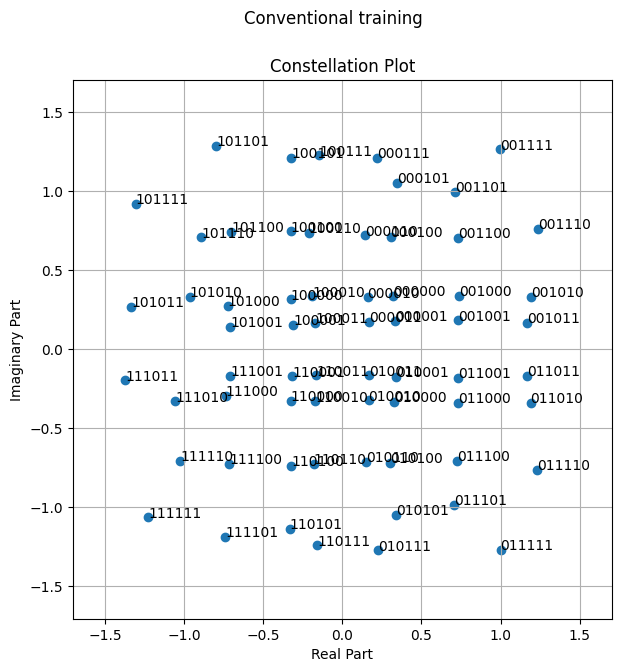

In [60]:
model_conventional = E2ESystemConventionalTraining(training=True)
load_weights(model_conventional, model_weights_path_conventional_training)
fig = model_conventional.constellation.show()
fig.suptitle('Conventional training');

*********Inside Gaussian Distributed PN************


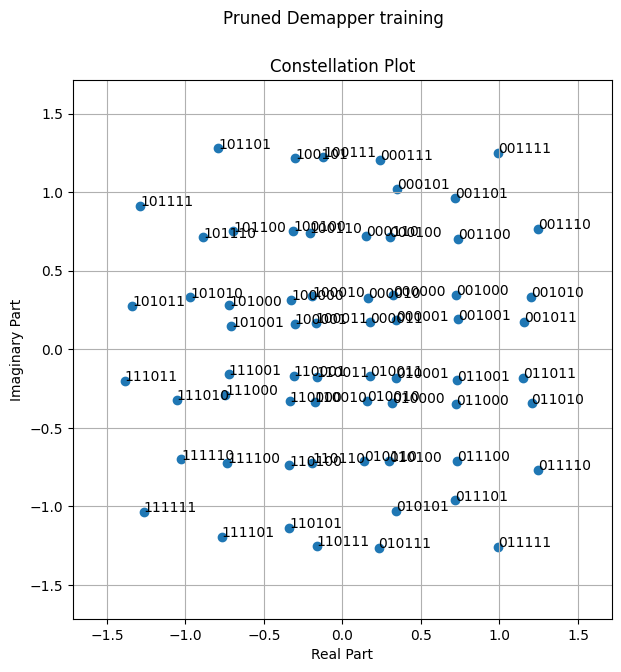

In [61]:
model_pruned_eval = E2ESystemConventionalTraining_Pruned(training=True)
load_weights(model_pruned_eval, model_weights_path_conventional_training_pruned)
fig = model_pruned_eval.constellation.show()
fig.suptitle('Pruned Demapper training');

*********Inside Gaussian Distributed PN************


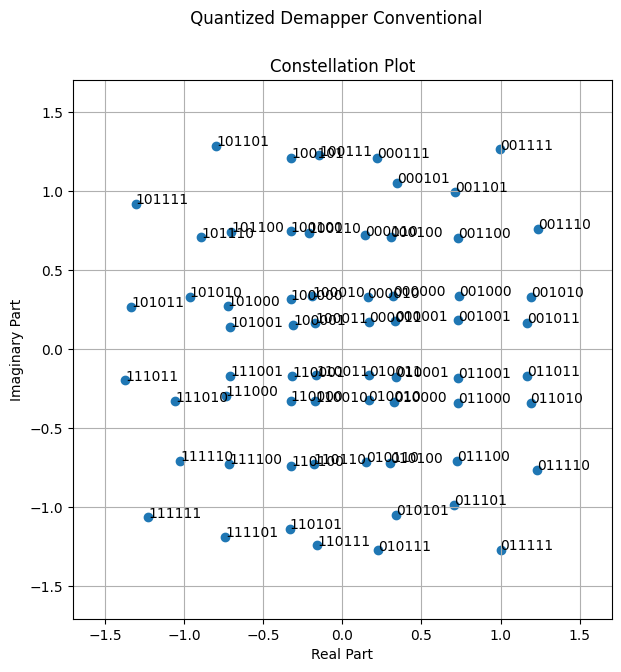

In [62]:
model_quantized = E2ESystemConventionalTraining(training=True)
model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")
load_weights(model_quantized, model_weights_path_quantized_conventional_training)

fig = model_quantized.constellation.show()
fig.suptitle(' Quantized Demapper Conventional');

In [63]:
# model_rl = E2ESystemRLTraining(training=False)
# load_weights(model_rl, model_weights_path_rl_training)
# fig = model_rl.constellation.show()
# fig.suptitle('RL-based training');

In [64]:
# %rm awgn_autoencoder_weights_conventional_training awgn_autoencoder_weights_rl_training awgn_autoencoder_results

## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.